# Milestone Project : SkimLit

The purpose of this notebook is to build an NLP model to make reading medical abstracts easier.
The paper we are  replicating(the source of the dataset that we will be using) is avilable here:[dataset_using](https://arxiv.org/abs/1710.06071)
and reading through the paper above, we see that the model architecture that they use to achieve their best result is avilable here:[best_result_model](https://arxiv.org/abs/1612.05251)


## Confirm access to Github

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-1a161b11-0d4d-311b-1dd4-afbfdbe4dbce)


# Get data
Before we can start building a model, we've got to download the PubMed 200k RCT dataset.

In a phenomenal act of kindness, the authors of the paper have made the data they used for their research availably publically and for free in the form of .txt files on GitHub.

We can copy them to our local directory using git clone https://github.com/Franck-Dernoncourt/pubmed-rct.


In [ ]:


!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct


Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25
Receiving objects: 100% (39/39), 177.08 MiB | 27.79 MiB/s, done.
Resolving deltas: 100% (15/15), done.
Updating files: 100% (13/13), done.
PubMed_200k_RCT				       PubMed_20k_RCT_numbers_replaced_with_at_sign
PubMed_200k_RCT_numbers_replaced_with_at_sign  README.md
PubMed_20k_RCT


#ls command
What is the ls Command in Linux? The ls command line utility lists all the files and directories under a specified directory-

In [ ]:
# Check what files are in the PubMed_20k dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


# dev.txt-validation dataset

In [ ]:
# Start our experiments using the 20k dataset with numbers replaced by"@" sign

data_dir="/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [ ]:
# Check all of the filenames in the target directory
import os
filenames=[data_dir+filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

# Preprocess data

 Now we've got some text data,it's time to become one with it.

 And one of the best ways to become one with data is to....

 ```
 Visualize,Visualize,Visualize
 ```
So with that in mind,let's write a function to read in all of the lines of a target text file

In [ ]:
# Create function to read the lines of a document
def get_lines(filename):
  """
  Reads filename (a text file) and returns the lines of text as a list.

  Args:
      filename: a string containing the target filepath to read.

  Returns:
      A list of strings with one string per line from the target filename.
      For example:
      ["this is the first line of filename",
       "this is the second line of filename",
       "..."]
  """
  with open(filename, "r") as f:
    return f.readlines()

In [ ]:
# Let's read in the training lines
train_lines=get_lines(data_dir+"train.txt")

In [ ]:
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [ ]:
len(train_lines)

210040

Let's think about how we want our data to look...

How I think our data would be best represented

In [ ]:
train_lines[:5]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n']

In [ ]:
def preprocess_text_with_line_numbers(filename):
  """Returns a list of dictionaries of abstract line data.

  Takes in filename, reads its contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence number
  the target line is.

  Args:
      filename: a string of the target text file to read and extract line data
      from.

  Returns:
      A list of dictionaries each containing a line from an abstract,
      the lines label, the lines position in the abstract and the total number
      of lines in the abstract where the line is from. For example:

      [{"target": 'CONCLUSION',
        "text": The study couldn't have gone better, turns out people are kinder than you think",
        "line_number": 8,
        "total_lines": 8}]
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts

  # Loop through each line in target file
  for line in input_lines:
    if line.startswith("###"): # check to see if line is an ID line
      abstract_id = line
      abstract_lines = "" # reset abstract string
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in abstract and count them at the same time
      for abstract_line_number,abstract_line in enumerate(abstract_line_split):
       line_data={} # create empty dict to store data from line
       target_text_split=abstract_line.split("\t") #split target
       line_data["target"]=target_text_split[0] # get target label
       line_data["text"]=target_text_split[1].lower()  # get target text and lower it
       line_data["line_number"]=abstract_line_number # what number lines does the line appear in the abstract?
       line_data["total_lines"]=len(abstract_line_split)-1 # how many total lines are in the abstract?(start from 0)
       abstract_samples.append(line_data)  # add line data to abstract samples list
    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines+= line
  return abstract_samples




In [ ]:
%%time
train_samples=preprocess_text_with_line_numbers(data_dir+"train.txt")
val_samples=preprocess_text_with_line_numbers(data_dir+"dev.txt") # dev is another name for validation set
test_samples=preprocess_text_with_line_numbers(data_dir+"test.txt")
len(train_samples),len(val_samples),len(test_samples)

CPU times: user 758 ms, sys: 154 ms, total: 912 ms
Wall time: 1.38 s


(180040, 30212, 30135)

In [ ]:
# check the first abstract of our training data
train_samples[:14]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [ ]:
train_lines[:5]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n']

In [ ]:
import pandas as pd
train_df=pd.DataFrame(train_samples)
val_df=pd.DataFrame(val_samples)
test_df=pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [ ]:
# Distribution of labels in training data
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

<Axes: >

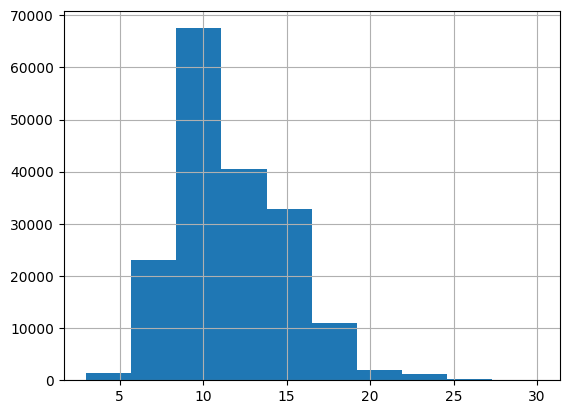

In [ ]:
train_df.total_lines.hist()

In [ ]:
# Convert abstract text lines into lists
train_sentences=train_df["text"].tolist()
val_sentences=val_df["text"].tolist()
test_sentences=test_df["text"].tolist()
len(train_sentences),len(val_sentences),len(test_sentences)

(180040, 30212, 30135)

In [ ]:
# View first 10 lines of training sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

# Make numeric labels (ML models require numeric labels)
We're going to create one hot and label encoded labels.

We could get away with just making label encoded labels, however, TensorFlow's CategoricalCrossentropy loss function likes to have one hot encoded labels (this will enable us to use label smoothing later on).

To numerically encode labels we'll use Scikit-Learn's **OneHotEncoder** and
**LabelEncoder** classes.

In [ ]:
# one hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder=OneHotEncoder(sparse=False)
train_labels_one_hot=one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
val_labels_one_hot=one_hot_encoder.fit_transform(val_df["target"].to_numpy().reshape(-1,1))
test_labels_one_hot=one_hot_encoder.fit_transform(test_df["target"].to_numpy().reshape(-1,1))

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

# Label encode labels



In [ ]:
# Extract labels("target" columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder
Label_encoder=LabelEncoder()
train_labels_encoded=Label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded=Label_encoder.fit_transform(val_df["target"].to_numpy())
test_labels_encoded=Label_encoder.fit_transform(test_df["target"].to_numpy())

In [ ]:
# check what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [ ]:
# Get class names and number of classes from LabelEncoder instance
num_classes=len(Label_encoder.classes_)
class_names=Label_encoder.classes_
num_classes,class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

# Model 0: Getting a baseline
Our first model we'll be a TF-IDF Multinomial Naive Bayes as recommended by Scikit-Learn's machine learning map.

To build it, we'll create a Scikit-Learn Pipeline which uses the TfidfVectorizer class to convert our abstract sentences to numbers using the TF-IDF (term frequency-inverse document frequecy) algorithm and then learns to classify our sentences using the MultinomialNB aglorithm.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline
model_0=Pipeline([
  ("tf-idf",TfidfVectorizer()),
  ("clf",MultinomialNB())
])


# Fit the pipeline to the training data
model_0.fit(X=train_sentences,
            y=train_labels_encoded);

Due to the speed of the Multinomial Naive Bayes algorithm, it trains very quickly.

We can evaluate our model's accuracy on the validation dataset using the score() method.

In [ ]:
# Evaluate baseline on validation dataset
model_0.score(X=val_sentences,
              y=val_labels_encoded)

0.7218323844829869

Nice! Looks like 72.1% accuracy will be the number to beat with our deeper models.

Now let's make some predictions with our baseline model to further evaluate it.

In [ ]:
# Make predictions
baseline_preds=model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

To evaluate our baseline's predictions, we'll import the calculate_results()



function we created in the another functions notebook and added it to our helper_functions.py script to compare them to the ground truth labels.

More specificially the calculate_results() function will help us obtain the following:  

*   Accuracy
*   Precision


*   Recall
*   F1-score









In [ ]:
# Download helper functions script
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-01-24 03:59:07--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-01-24 03:59:07 (20.7 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
# Import calculate_results helper functions
from helper_functions import calculate_results

In [ ]:
# Calculate baseline results
baseline_results=calculate_results(y_true=val_labels_encoded,
                                   y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

 # Preparing our data for deep sequence models
Excellent! We've got a working baseline to try and improve upon.

But before we start building deeper models, we've got to create vectorization and embedding layers.

The vectorization layer will convert our text to numbers and the embedding layer will capture the relationships between those numbers.

To start creating our vectorization and embedding layers, we'll need to import the appropriate libraries (namely TensorFlow and NumPy)

In [ ]:
sent=[sentence.split() for sentence in train_sentences]

In [ ]:
type(sent)

list

In [ ]:

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
sent_lens=[len(sentence.split()) for sentence in train_sentences]
avg_sent_len=np.mean(sent_lens)
avg_sent_len # return average sentence length(in tokens)

26.338269273494777

How about the distribution of sentence lengths?

(array([1.5999e+05, 1.8760e+04, 1.1510e+03, 9.9000e+01, 2.8000e+01,
        1.0000e+01, 2.0000e+00]),
 array([  1.        ,  43.14285714,  85.28571429, 127.42857143,
        169.57142857, 211.71428571, 253.85714286, 296.        ]),
 <BarContainer object of 7 artists>)

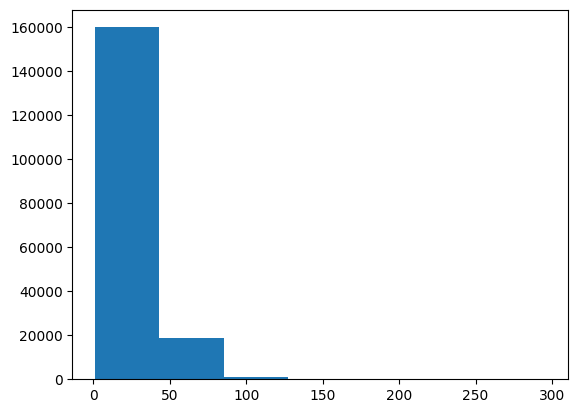

In [ ]:
# What's the distribution look like?
import matplotlib.pyplot as plt
plt.hist(sent_lens,bins=7)

Looks like the vast majority of sentences are between 0 and 50 tokens in length.

We can use NumPy's percentile to find the value which covers 95% of the sentence lengths.

In [ ]:
# How long of a sentence covers 95% of the lengths?
output_seq_len=int(np.percentile(sent_lens,95))
output_seq_len

55

Wonderful! It looks like 95% of the sentences in our training set have a length of 55 tokens or less.

When we create our tokenization layer, we'll use this value to turn all of our sentences into the same length. Meaning sentences with a length below 55 get padded with zeros and sentences with a length above 55 get truncated (words after 55 get cut off).
```
🤔 Question: Why 95%?
```

We could use the max sentence length of the sentences in the training set.

In [ ]:
# maximum sentence length in the training set
max(sent_lens)

296

However, since hardly any sentences even come close to the max length, it would mean the majority of the data we pass to our model would be zeros (sinces all sentences below the max length would get padded with zeros).

# Create text vectorizer
Now we've got a little more information about our texts, let's create a way to turn it into numbers.

To do so, we'll use the TextVectorization layer from TensorFlow.

We'll keep all the parameters default except for max_tokens (the number of unique words in our dataset) and output_sequence_length (our desired output length for each vectorized sentence).

Section 3.2 of the PubMed 200k RCT paper states the vocabulary size of the PubMed 20k dataset as 68,000. So we'll use that as our max_tokens parameter.

In [ ]:
# How many words are in our vocabulary?
max_tokens=68000

And since discovered a sentence length of 55 covers 95% of the training sentences, we'll use that as our output_sequence_length parameter.

In [ ]:
# Create text vectorizer

from tensorflow.keras.layers import TextVectorization

text_vectorizer=TextVectorization(max_tokens=max_tokens,output_sequence_length=55)


Great! Looks like our text_vectorizer is ready, let's adapt it to the training data (let it read the training data and figure out what number should represent what word) and then test it out.

In [ ]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [ ]:
# Test out text vectorizer
import random
target_sentence=random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of texgt:{len(target_sentence.split())}")
print(f"\nVectorized text:\n{text_vectorizer([target_sentence])}")

Text:
the overall ast rate was @ % and was higher with bivalirudin than with heparin gpi ( @ % vs. @ % ; p = @ ) .

Length of texgt:28

Vectorized text:
[[   2  188 4047   78   10    3   10   82    7 4214   42    7 2035 6942
    44   14    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]


In [ ]:
# How many words in our training vocabulary?
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocabulary: {len(rct_20k_text_vocab)}"),
print(f"Most common words in the vocabulary: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocabulary: {rct_20k_text_vocab[-5:]}")


Number of words in vocabulary: 64841
Most common words in the vocabulary: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocabulary: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


And if we wanted to figure out the configuration of our text_vectorizer we can use the get_config() method.

In [ ]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

In [ ]:
train_labels_one_hot[3]

array([0., 0., 1., 0., 0.])

In [ ]:
len(train_sentences)

180040

# Create custom text embedding
Our token_vectorization layer maps the words in our text directly to numbers. However, this doesn't necessarily capture the relationships between those numbers.

To create a richer numerical representation of our text, we can use an embedding.

As our model learns (by going through many different examples of abstract sentences and their labels), it'll update its embedding to better represent the relationships between tokens in our corpus

In [ ]:
# Create token embedding layer
token_embed=layers.Embedding(input_dim=len(rct_20k_text_vocab),# Length of vocabulary
                             output_dim=128,
                             mask_zero=True,
                             name="token_embedding"
                             )

# Show example Embedding
print(f"Sentence before vectorization :\n{target_sentence}\n")
vectorized_sentence=text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding) :\n{vectorized_sentence}\n")
embedded_sentence=token_embed(vectorized_sentence)
print(f"Sentence after embedding :\n{embedded_sentence}\n")
print(f"Embedded sentence shape:{embedded_sentence.shape}")

Sentence before vectorization :
the overall ast rate was @ % and was higher with bivalirudin than with heparin gpi ( @ % vs. @ % ; p = @ ) .

Sentence after vectorization (before embedding) :
[[   2  188 4047   78   10    3   10   82    7 4214   42    7 2035 6942
    44   14    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]

Sentence after embedding :
[[[ 0.041283   -0.0115641   0.03238383 ...  0.04214728 -0.03831477
   -0.0088285 ]
  [-0.03393576 -0.04865773  0.02983972 ...  0.04504598  0.04676988
   -0.03388934]
  [ 0.04719684  0.04186989 -0.02580329 ... -0.02493631 -0.03349461
   -0.02590454]
  ...
  [ 0.03300435  0.01235807 -0.0344949  ... -0.01698474 -0.03289554
   -0.03259306]
  [ 0.03300435  0.01235807 -0.0344949  ... -0.01698474 -0.03289554
   -0.03259306]
  [ 0.03300435  0.01235807 -0.0344949  ... -0.01698474 -0.03289554
   -0.0

# Create datasets (as fast as possible)
We've gone through all the trouble of preprocessing our datasets to be used with a machine learning model, however, there are still a few steps we can use to make them work faster with our models.

Namely, the tf.data API provides methods which enable faster data loading.

The main steps we'll want to use with our data is to turn it into a PrefetchDataset of batches.

Doing so we'll ensure TensorFlow loads our data onto the GPU as fast as possible, in turn leading to faster training time.

To create a batched PrefetchDataset we can use the methods batch() and prefetch(), the parameter tf.data.AUTOTUNE will also allow TensorFlow to determine the optimal amount of compute to use to prepare datasets.

In [ ]:
# Take our data into Tensorflow Datasets
train_dataset=tf.data.Dataset.from_tensor_slices((train_sentences,train_labels_one_hot))
valid_dataset=tf.data.Dataset.from_tensor_slices((val_sentences,val_labels_one_hot))
test_dataset=tf.data.Dataset.from_tensor_slices((test_sentences,test_labels_one_hot))

In [ ]:
train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [ ]:
# Take the TensorSliceDataset's and turn them into prefetched batches
train_dataset=train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset=valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
train_dataset=test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

# Model 1: Conv1D with token embeddings
Alright, we've now got a way to numerically represent our text and labels, time to build a series of deep models to try and improve upon our baseline.

All of our deep models will follow a similar structure:
```
Input (text) -> Tokenize -> Embedding -> Layers -> Output (label probability)
```

The first model we're going to build is a 1-dimensional Convolutional Neural Network.

We're also going to be following the standard machine learning workflow of:


*   Build model
*   Train model


*   Evaluate model(make predictions and compare to ground truth)






In [ ]:
# Create 1D convolutional model to process sequences
inputs=layers.Input(shape=(1,),dtype=tf.string)
text_vectors=text_vectorizer(inputs) # vectorize text inputs
token_embeddings=token_embed(text_vectors) # create embedding
x=layers.Conv1D(64,kernel_size=5,padding='same',activation="relu")(token_embeddings)
x=layers.GlobalAveragePooling1D()(x) # condense the output of our feature vector
outputs=layers.Dense(num_classes,activation="softmax")(x)
model_1=tf.keras.Model(inputs,outputs)

# compile the model
model_1.compile(loss="categorical_crossentropy", # if your labels are integer from (not one hot ) use sparse_categoircal_crossentropy
               optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


In [ ]:
num_classes

5

In [ ]:
# Get summary of Conv1D model
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 55)                0         
 ctorization)                                                    
                                                                 
 token_embedding (Embedding  (None, 55, 128)           8299648   
 )                                                               
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (  (None, 64)                0         
 GlobalAveragePooling1D)                                         
                                                             

It's time to fit our model to the training data but we're going to make a mindful change.

Since our training data contains nearly 200,000 sentences, fitting a deep model may take a while even with a GPU. So to keep our experiments swift, we're going to run them on a subset of the training dataset.

More specifically, we'll only use the first 10% of batches (about 18,000 samples) of the training set to train on and the first 10% of batches from the validation set to validate on.

In [ ]:
# fit the model
model_1_history=model_1.fit(train_dataset,
                            steps_per_epoch=(0.1*len(train_dataset)),
                            epochs=3,
                            validation_data=valid_dataset,
                            validation_steps=int(0.1*len(valid_dataset)))

Epoch 1/3
94/94 [==============================] - 11s 80ms/step - loss: 1.4371 - accuracy: 0.3523 - val_loss: 1.3322 - val_accuracy: 0.4784
Epoch 2/3
94/94 [==============================] - 3s 36ms/step - loss: 1.0958 - accuracy: 0.5855 - val_loss: 0.8938 - val_accuracy: 0.6393
Epoch 3/3
94/94 [==============================] - 3s 32ms/step - loss: 0.8633 - accuracy: 0.6648 - val_loss: 0.7919 - val_accuracy: 0.6828


Brilliant! We've got our first trained deep sequence model, and it didn't take too long (and if we didn't prefetch our batched data, it would've taken longer).

Time to make some predictions with our model and then evaluate them.

In [ ]:
# Evaluate on whole validation dataset (We only validated on 10% of batches during training)
model_1.evaluate(valid_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.7956 - accuracy: 0.6887


[0.7955551147460938, 0.6886998414993286]

In [ ]:
# Make predictions(our model outputs prediction probabilities for each lines)
model_1_pred_probs=model_1.predict(valid_dataset)
model_1_pred_probs

945/945 [==============================] - 2s 2ms/step


array([[0.33720282, 0.33101428, 0.11691242, 0.15840325, 0.05646721],
       [0.42801204, 0.39680928, 0.0333277 , 0.1197015 , 0.02214954],
       [0.47155946, 0.2668873 , 0.03996802, 0.21744171, 0.00414352],
       ...,
       [0.00204134, 0.01003355, 0.05964618, 0.0022093 , 0.9260696 ],
       [0.04172198, 0.0810352 , 0.45889008, 0.04623011, 0.3721226 ],
       [0.38799354, 0.24532309, 0.17832814, 0.11745327, 0.07090198]],
      dtype=float32)

In [ ]:
# convert pred probs to classes
model_1_preds=tf.argmax(model_1_pred_probs,axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 0, ..., 4, 2, 0])>

In [ ]:
# Calculate model_1 results
model_1_results=calculate_results(y_true=val_labels_encoded,
                                  y_pred=model_1_preds)
model_1_results

{'accuracy': 68.86998543625049,
 'precision': 0.6794577803714328,
 'recall': 0.6886998543625049,
 'f1': 0.6596296644771337}

In [ ]:

# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")


In [ ]:
random_training_sentence = random.choice(train_sentences)
use_embedded_sentence = tf_hub_embedding_layer([random_training_sentence])
use_embedded_sentence[0][:30]

<tf.Tensor: shape=(30,), dtype=float32, numpy=
array([-1.32583338e-03, -1.50960926e-02,  4.71370704e-02, -6.63356632e-02,
        8.50400608e-03,  7.55018974e-03,  1.59216486e-03, -2.95105334e-02,
        4.84589040e-02,  4.19954062e-02,  9.54851434e-02,  1.26138525e-02,
        7.52967671e-02,  4.77790795e-02, -4.08362411e-02, -2.64288243e-02,
       -9.59019139e-02, -4.92477715e-02, -3.06959124e-03,  5.30839339e-02,
        6.67455560e-03,  4.65002097e-02,  3.23677510e-02, -4.70241420e-02,
        4.75787483e-02, -2.33353414e-02,  2.62553412e-02,  2.43408158e-05,
       -5.41574545e-02,  3.98083255e-02], dtype=float32)>

In [ ]:
# Test out the embedding on a random sentence
random_training_sentence=random.choice(train_sentences)
print(f"Random training sentence :\n {random_training_sentence}")
use_embedded_sentence=tf_hub_embedding_layer([random_training_sentence])
print(f"Sentence after embedding :\n{use_embedded_sentence[0][:30]} (truncated output)....\n")
print(f"Length of sentence embedding:\n{len(use_embedded_sentence[0])}")

Random training sentence :
 the number of attempts for a successful insertion and the sealing pressure and leak volume @ seconds and @ minutes after initiating mechanical ventilation .
Sentence after embedding :
[ 0.01460394 -0.03537137 -0.06467743 -0.00521571  0.01596277 -0.02656281
  0.05629566 -0.04322121  0.03230314  0.0350196   0.0415039   0.01377227
  0.02859128 -0.03411144 -0.01427221 -0.02268276  0.0535856  -0.03093686
 -0.0528602  -0.00430288  0.01485605  0.0695578  -0.05849719  0.01394889
 -0.03952911 -0.02153259 -0.06359208 -0.01266425 -0.07904403 -0.05952414] (truncated output)....

Length of sentence embedding:
512


# Building and fitting an NLP feature extraction model from TensorFlow Hub

In [ ]:
# Define feature extractor model using TF Hub layer
inputs=layers.Input(shape=[],dtype=tf.string)
pretrained_embedding=tf_hub_embedding_layer(inputs) # tokenize text and create embedding
x=layers.Dense(128,activation="relu")(pretrained_embedding) # and a fully connected on top of the embedding
# Note : you could add more layers here if you wanted to
outputs=layers.Dense(5,activation="softmax")(x) # Create the output layer
model_2=tf.keras.Model(inputs=inputs,
                       outputs=outputs)

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder  (None, 512)               256797824 
  (KerasLayer)                                                   
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256864133 (979.86 MB)
Trainable params: 66309 (259.02 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [ ]:
# Fit feature extractor model for 3 epochs
model_2.fit(train_dataset,
            steps_per_epoch=int(0.1*len(train_dataset)),
            epochs=3,
            validation_data=valid_dataset,
            validation_steps=int(0.1*len(valid_dataset)))

Epoch 1/3
94/94 [==============================] - 6s 30ms/step - loss: 1.2467 - accuracy: 0.5236 - val_loss: 1.0186 - val_accuracy: 0.6007
Epoch 2/3
94/94 [==============================] - 2s 25ms/step - loss: 0.9244 - accuracy: 0.6303 - val_loss: 0.8700 - val_accuracy: 0.6659
Epoch 3/3
94/94 [==============================] - 2s 20ms/step - loss: 0.8693 - accuracy: 0.6669 - val_loss: 0.8269 - val_accuracy: 0.6772


In [ ]:
# Evaluate on whole validation dataset
model_2.evaluate(valid_dataset)

945/945 [==============================] - 11s 11ms/step - loss: 0.8296 - accuracy: 0.6801


[0.8295682072639465, 0.6801270842552185]

In [ ]:
# Make predictions with feature extraction model
model_2_pred_probs=model_2.predict(valid_dataset)
model_2_pred_probs

945/945 [==============================] - 11s 11ms/step


array([[0.537777  , 0.28031528, 0.01941362, 0.12868606, 0.03380807],
       [0.3977656 , 0.4610972 , 0.01596746, 0.10542383, 0.01974593],
       [0.3606419 , 0.2562977 , 0.05186862, 0.24175441, 0.0894374 ],
       ...,
       [0.00496571, 0.00488788, 0.1621173 , 0.00224192, 0.8257872 ],
       [0.01162464, 0.02905945, 0.2450728 , 0.00531746, 0.70892566],
       [0.20726226, 0.09248661, 0.5268603 , 0.04654077, 0.12684998]],
      dtype=float32)

In [ ]:
# Convert the predictions with feature extraction model to classes
model_2_preds=tf.argmax(model_2_pred_probs,axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 0, ..., 4, 4, 2])>

In [ ]:
# Calculate results from Tf Hub pretrained embeddings results on validation set
model_2_results=calculate_results(y_true=val_labels_encoded,
                                  y_pred=model_2_preds)

In [ ]:
model_2_results

{'accuracy': 68.01271018138489,
 'precision': 0.6815578075909878,
 'recall': 0.6801271018138488,
 'f1': 0.6714979147771988}

In [ ]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

In [ ]:
model_1_results

{'accuracy': 68.86998543625049,
 'precision': 0.6794577803714328,
 'recall': 0.6886998543625049,
 'f1': 0.6596296644771337}

# Model 3: Conv1D with character embeddings
Creating a character-level tokenizer
The Neural Networks for Joint Sentence Classification in Medical Paper Abstracts paper mentions their model uses a hybrid of token and character embeddings.

We've built models with a custom token embedding and a pretrained token embedding, how about we build one using a character embedding?

The difference between a character and token embedding is that the character embedding is created using sequences split into characters (e.g. hello -> [h, e, l, l, o]) where as a token embedding is created on sequences split into tokens.

We can create a character-level embedding by first vectorizing our sequences (after they've been split into characters) using the TextVectorization class and then passing those vectorized sequences through an Embedding layer."

# Before we can vectorize our sequences on a character-level we'll need to split them into characters. Let's write a function to do so.

In [ ]:
# Make function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

# Test splitting non-character-level sequence into characters
split_chars(random_training_sentence)

't h e   n u m b e r   o f   a t t e m p t s   f o r   a   s u c c e s s f u l   i n s e r t i o n   a n d   t h e   s e a l i n g   p r e s s u r e   a n d   l e a k   v o l u m e   @   s e c o n d s   a n d   @   m i n u t e s   a f t e r   i n i t i a t i n g   m e c h a n i c a l   v e n t i l a t i o n   .'

# Great! Looks like our character-splitting function works. Let's create character-level datasets by splitting our sequence datasets into characters.

In [ ]:
# Split sequence-level data splits into character-level data splits
train_chars=[split_chars(sentence) for sentence in train_sentences]
val_chars=[split_chars(sentence) for sentence in val_sentences]
test_chars=[split_chars(sentence) for sentence in test_sentences]
print(train_chars[0])

t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .


# To figure out how long our vectorized character sequences should be, let's check the distribution of our character sequence lengths.

In [ ]:
# What's the average character length?
char_lens=[len(sentence) for sentence in train_sentences]
mean_char_len=np.mean(char_lens)
mean_char_len

149.3662574983337

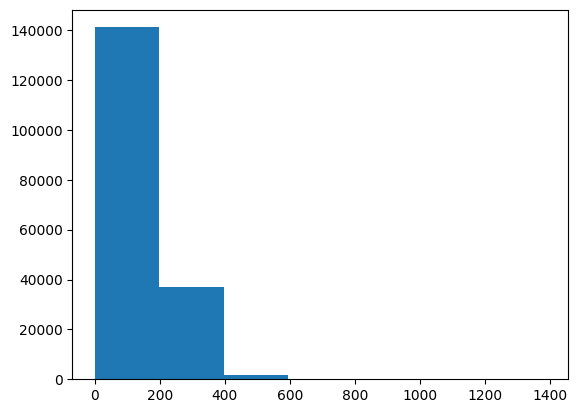

In [ ]:
# Check the distribution of our sequences at character-level
import matplotlib.pyplot as plt
plt.hist(char_lens,bins=7);

Okay, looks like most of our sequences are between 0 and 200 characters long.

Let's use NumPy's percentile to figure out what length covers 95% of our sequences.

In [ ]:
# Find what character length color 95% of sequences
output_seq_char_len=int(np.percentile(char_lens,95))
output_seq_char_len

290

# Wonderful, now we know the sequence length which covers 95% of sequences, we'll use that in our TextVectorization layer as the output_sequence_length parameter.





In [ ]:
# Get all keyboard characters for char-level embedding
import string
alphabet=string.ascii_lowercase+string.digits+string.punctuation
alphabet


'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
len(alphabet)

68

In [ ]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS=len(alphabet)+2 # num characters in alphabet +space+ OOV token
char_vectorizer=TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                  output_sequence_length=output_seq_char_len,
                                  standardize=None,
                                  name="char_vectorizer")

# Adapt character vectorizer to training characters
char_vectorizer.adapt(train_chars)

In [ ]:
from sys import prefix
# Check character vocabulary characteristics
char_vocab=char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f" 5 least common characters:{char_vocab[-5:]}")

Number of different characters in character vocab: 57
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
 5 least common characters:['|', '"', ']', '\\', '[']


In [ ]:
random_train_chars=random.choice(train_chars)
print(f"{random_train_chars}\n")
print(f"{random_train_chars.split()}\n")
print(f"random_train_chars_len: {len(random_train_chars)}\n")
print(f"random_train_chars_split_len:{len(random_train_chars.split())}\n")

w e i g h t   ,   i n s u l i n   s e n s i t i v i t y   ,   a n d   h y p e r g l y c e m i a   d i f f e r e n c e s   e a c h   a c c o u n t e d   f o r   t h e   i n f l u e n c e   o f   d i a b e t e s   o n   t h e   t p a   r e s p o n s e   .

['w', 'e', 'i', 'g', 'h', 't', ',', 'i', 'n', 's', 'u', 'l', 'i', 'n', 's', 'e', 'n', 's', 'i', 't', 'i', 'v', 'i', 't', 'y', ',', 'a', 'n', 'd', 'h', 'y', 'p', 'e', 'r', 'g', 'l', 'y', 'c', 'e', 'm', 'i', 'a', 'd', 'i', 'f', 'f', 'e', 'r', 'e', 'n', 'c', 'e', 's', 'e', 'a', 'c', 'h', 'a', 'c', 'c', 'o', 'u', 'n', 't', 'e', 'd', 'f', 'o', 'r', 't', 'h', 'e', 'i', 'n', 'f', 'l', 'u', 'e', 'n', 'c', 'e', 'o', 'f', 'd', 'i', 'a', 'b', 'e', 't', 'e', 's', 'o', 'n', 't', 'h', 'e', 't', 'p', 'a', 'r', 'e', 's', 'p', 'o', 'n', 's', 'e', '.']

random_train_chars_len: 253

random_train_chars_split_len:108



In [ ]:
type(random_train_chars.split())

list

In [ ]:
type(random_train_chars)

str

# len() for **String**
It returns the number of characters in a string, which includes punctuation, space, and all type of special characters. However, you should be very careful while using len of a Null variable.



In [ ]:
# Test out character vectorizer
print(f"Charified text:\n{random_train_chars}")
print(f"\nLength of chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n{vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
w e i g h t   ,   i n s u l i n   s e n s i t i v i t y   ,   a n d   h y p e r g l y c e m i a   d i f f e r e n c e s   e a c h   a c c o u n t e d   f o r   t h e   i n f l u e n c e   o f   d i a b e t e s   o n   t h e   t p a   r e s p o n s e   .

Length of chars: 108

Vectorized chars:
[[21  2  4 18 13  3 24  4  6  9 16 12  4  6  9  2  6  9  4  3  4 22  4  3
  20 24  5  6 10 13 20 14  2  8 18 12 20 11  2 15  4  5 10  4 17 17  2  8
   2  6 11  2  9  2  5 11 13  5 11 11  7 16  6  3  2 10 17  7  8  3 13  2
   4  6 17 12 16  2  6 11  2  7 17 10  4  5 23  2  3  2  9  7  6  3 13  2
   3 14  5  8  2  9 14  7  6  9  2 25  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0 

# Creating a character-level embedding
We've got a way to vectorize our character-level sequences, now's time to create a character-level embedding.

Just like our custom token embedding, we can do so using the tensorflow.keras.layers.Embedding class.

Our character-level embedding layer requires an input dimension and output dimension.

In [ ]:
# Create char embedding layer
char_embed=layers.Embedding(input_dim=NUM_CHAR_TOKENS,
                            output_dim=25,
                            mask_zero=False,
                            name="char_embed")
# Test out character embedding layer
print(f"Charifed text(before vectorization and embedding):\n{random_train_chars}")
char_embed_example=char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars(after vectorization and embedding):\n{char_embed_example}")
print(f"Character embedding shape: {char_embed_example.shape}")

Charifed text(before vectorization and embedding):
w e i g h t   ,   i n s u l i n   s e n s i t i v i t y   ,   a n d   h y p e r g l y c e m i a   d i f f e r e n c e s   e a c h   a c c o u n t e d   f o r   t h e   i n f l u e n c e   o f   d i a b e t e s   o n   t h e   t p a   r e s p o n s e   .
Embedded chars(after vectorization and embedding):
[[[-0.01266438  0.04882776  0.03670487 ... -0.02290376  0.02428008
   -0.02240521]
  [ 0.03748262 -0.02908416  0.02011601 ...  0.01167025 -0.04447582
    0.04779622]
  [ 0.00671535  0.01147084 -0.03075267 ...  0.00415717  0.02824625
    0.01093229]
  ...
  [-0.00031164  0.04589614 -0.03672081 ... -0.02481568  0.02665951
   -0.02525849]
  [-0.00031164  0.04589614 -0.03672081 ... -0.02481568  0.02665951
   -0.02525849]
  [-0.00031164  0.04589614 -0.03672081 ... -0.02481568  0.02665951
   -0.02525849]]]
Character embedding shape: (1, 290, 25)


# Building a Conv1D model to fit on character embeddings
Now we've got a way to turn our character-level sequences into numbers (char_vectorizer) as well as numerically represent them as an embedding (char_embed) let's test how effective they are at encoding the information in our sequences by creating a character-level sequence model.

The model will have the same structure as our custom token embedding model (model_1) except it'll take character-level sequences as input instead of token-level sequences

In [ ]:
# Make  Conv1D on chars only
inputs =layers.Input(shape=(1,),dtype="string")
char_vectors=char_vectorizer(inputs)
char_embeddings=char_embed(char_vectors)
x=layers.Conv1D(64,kernel_size=5,padding="same",activation="relu")(char_embeddings)
x=layers.GlobalMaxPool1D()(x)
outputs=layers.Dense(num_classes,activation="softmax")(x)
model_3=tf.keras.Model(inputs=inputs,
                       outputs=outputs,
                       name="model_3_Conv1D_char_embedding")

# Compile the model
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [ ]:
# Check the summary of conv1D_char_model
model_3.summary()

Model: "model_3_Conv1D_char_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVecto  (None, 290)               0         
 rization)                                                       
                                                                 
 char_embed (Embedding)      (None, 290, 25)           1750      
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense_3 (Dense)             (None, 5

# Before fitting our model on the data, we'll create char-level batched PrefetchedDataset's

In [ ]:
# Create char datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset=tf.data.Dataset.from_tensor_slices((val_chars,val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset=tf.data.Dataset.from_tensor_slices((test_chars,test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)


Just like our token-level sequence model, to save time with our experiments, we'll fit the character-level model on 10% of batches.

In [ ]:
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_dataset)),
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1 * len(val_char_dataset)))


Epoch 1/3
562/562 [==============================] - 6s 8ms/step - loss: 1.1815 - accuracy: 0.5328 - val_loss: 0.9441 - val_accuracy: 0.6257
Epoch 2/3
562/562 [==============================] - 3s 5ms/step - loss: 0.8913 - accuracy: 0.6486 - val_loss: 0.8495 - val_accuracy: 0.6669
Epoch 3/3
562/562 [==============================] - 4s 7ms/step - loss: 0.8299 - accuracy: 0.6765 - val_loss: 0.7879 - val_accuracy: 0.7035


In [ ]:
# Evaluate model_3 on whole validation char dataset

model_3.evaluate(val_char_dataset)

945/945 [==============================] - 4s 4ms/step - loss: 0.7913 - accuracy: 0.6918


[0.7913456559181213, 0.6918442845344543]

Nice! Looks like our character-level model is working, let's make some predictions with it and evaluate them.

In [ ]:
# Make predictions with character model only
model_3_pred_probs=model_3.predict(val_char_dataset)
model_3_pred_probs

945/945 [==============================] - 3s 3ms/step


array([[0.16416435, 0.51552236, 0.12131081, 0.15338181, 0.04562067],
       [0.25218013, 0.4686703 , 0.02558446, 0.18154112, 0.07202395],
       [0.12092028, 0.3298718 , 0.19193836, 0.13754907, 0.21972045],
       ...,
       [0.00234547, 0.00152064, 0.0301349 , 0.00283285, 0.9631662 ],
       [0.01562934, 0.11919449, 0.19333087, 0.01887205, 0.6529733 ],
       [0.43531126, 0.37715256, 0.09476638, 0.0606425 , 0.0321274 ]],
      dtype=float32)

In [ ]:
# Convert predictions to classes
model_3_preds=tf.argmax(model_3_pred_probs,axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 1, ..., 4, 4, 0])>

In [ ]:
# Calculate Conv1D char only model results
model_3_results=calculate_results(y_true=val_labels_encoded,
                                  y_pred=model_3_preds)

In [ ]:
model_3_results

{'accuracy': 69.18443002780353,
 'precision': 0.6963276288673388,
 'recall': 0.6918443002780352,
 'f1': 0.6816164074864491}

# Model 4: Combining pretrained token embeddings + character embeddings (hybrid embedding layer)
Alright, now things are going to get spicy.

In moving closer to build a model similar to the one in Figure 1 of Neural Networks for Joint Sentence Classification in Medical Paper Abstracts, it's time we tackled the hybrid token embedding layer they speak of.

This hybrid token embedding layer is a combination of token embeddings and character embeddings. In other words, they create a stacked embedding to represent sequences before passing them to the sequence label prediction layer.

So far we've built two models which have used token and character-level embeddings, however, these two models have used each of these embeddings exclusively.

To start replicating (or getting close to replicating) the model in Figure 1, we're going to go through the following steps:

Create a token-level model (similar to model_1)
Create a character-level model (similar to model_3 with a slight modification to reflect the paper)
Combine (using layers.Concatenate) the outputs of 1 and 2
Build a series of output layers on top of 3 similar to Figure 1 and section 4.2 of [*Neural Networks for Joint Sentence Classification

In [ ]:
#  1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_output)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings) # bi-LSTM shown in Figure 1 of https://arxiv.org/pdf/1612.05251.pdf
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output,
                                                                  char_model.output])

# 4. Create output layers - addition of dropout discussed in 4.2 of https://arxiv.org/pdf/1612.05251.pdf
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(200, activation="relu")(combined_dropout) # slightly different to Figure 1 due to different shapes of token/char embedding layers
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")

Woah... There's a lot going on here, let's get a summary and plot our model to visualize what's happening.

In [ ]:
# Get summary of token and character model

model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 token_input (InputLayer)    [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_input[0][0]']          
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978 

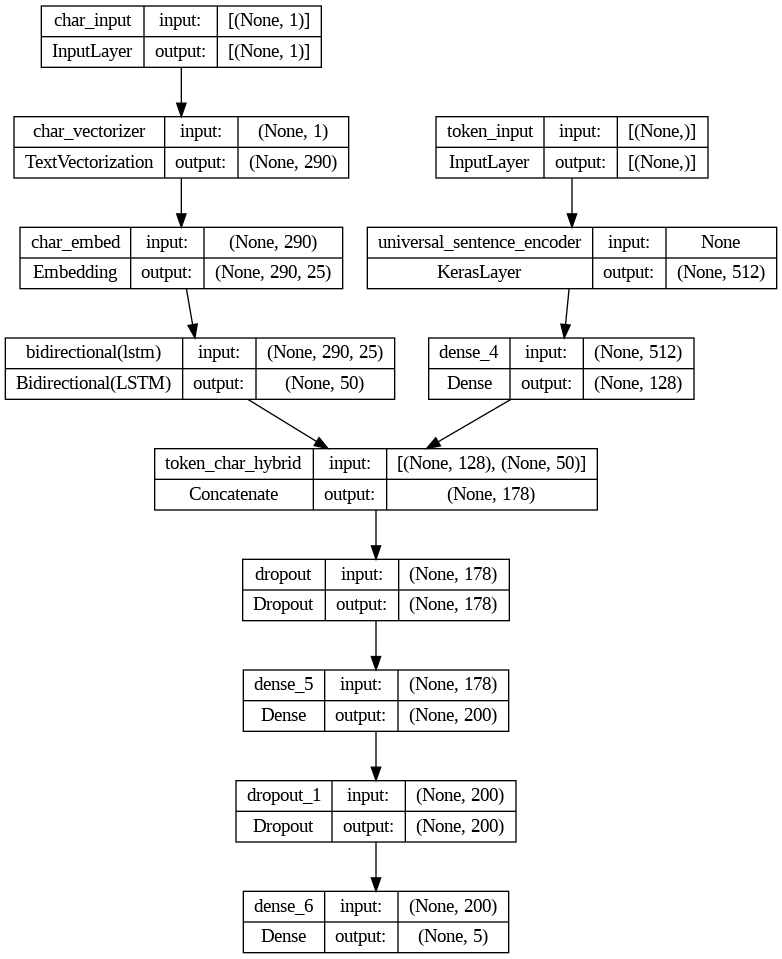

In [ ]:
# Plot hybrid token and character model
from keras.utils import plot_model
plot_model(model_4,show_shapes=True)

In [ ]:
 # Compile token char model
 model_4.compile(loss="categorical_crossentropy",
                 optimizer=tf.keras.optimizers.Adam(),
                 metrics=["accuracy"])

# Combine token and character data into a tf.data dataset


In [ ]:
# Combine chars and tokens into a dataset
train_char_token_data=tf.data.Dataset.from_tensor_slices((train_sentences,train_chars))
train_char_token_labels=tf.data.Dataset.from_tensor_slices((train_labels_one_hot))
train_char_token_dataset=tf.data.Dataset.zip((train_char_token_data,train_char_token_labels))


# Prefetch and batch train data
train_char_token_dataset=train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [ ]:
# Combine chars and tokens into a dataset
val_char_token_data=tf.data.Dataset.from_tensor_slices((val_sentences,val_chars))
val_char_token_labels=tf.data.Dataset.from_tensor_slices((val_labels_one_hot))
val_char_token_dataset=tf.data.Dataset.zip((val_char_token_data,val_char_token_labels))


# Prefetch and batch train data
val_char_token_dataset=val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [ ]:
### Fitting a model on token and character-level sequences

history_model_4=model_4.fit(train_char_token_dataset,
                            steps_per_epoch=int(0.1*len(train_char_token_dataset)),
                            epochs=3,
                            validation_data=val_char_token_dataset,
                            validation_steps=int(0.1*len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 29s 39ms/step - loss: 0.9662 - accuracy: 0.6174 - val_loss: 0.7794 - val_accuracy: 0.7018
Epoch 2/3
562/562 [==============================] - 21s 37ms/step - loss: 0.7895 - accuracy: 0.6997 - val_loss: 0.7051 - val_accuracy: 0.7360
Epoch 3/3
562/562 [==============================] - 22s 38ms/step - loss: 0.7598 - accuracy: 0.7131 - val_loss: 0.6794 - val_accuracy: 0.7467


In [ ]:
# Evaluate one the whole validation dataset
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 19s 21ms/step - loss: 0.6808 - accuracy: 0.7429


[0.6808255314826965, 0.7429498434066772]

In [ ]:
 model_4_pred_probs=model_4.predict(val_char_token_dataset)
 model_4_pred_probs

945/945 [==============================] - 19s 19ms/step


array([[4.23925310e-01, 2.62336671e-01, 4.41627624e-03, 3.04288983e-01,
        5.03272051e-03],
       [2.80677259e-01, 5.46573341e-01, 3.62369814e-03, 1.67700768e-01,
        1.42488233e-03],
       [2.72879988e-01, 1.14941515e-01, 4.15829085e-02, 5.45964837e-01,
        2.46306919e-02],
       ...,
       [4.04251652e-04, 5.03124064e-03, 5.21313995e-02, 1.03194674e-04,
        9.42329943e-01],
       [5.05075743e-03, 4.16104198e-02, 2.32287243e-01, 1.64940045e-03,
        7.19402194e-01],
       [1.48060486e-01, 6.36935115e-01, 1.42084077e-01, 1.97300781e-02,
        5.31902276e-02]], dtype=float32)

In [ ]:
# Format pred probs into pred labels
model_4_preds=tf.argmax(model_4_pred_probs,axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 1])>

In [ ]:
# get results of token_char_hybrid model
model_4_results=calculate_results(y_true=val_labels_encoded,
                                  y_pred=model_4_preds)
model_4_results

{'accuracy': 74.29498212630743,
 'precision': 0.7464650938519879,
 'recall': 0.7429498212630743,
 'f1': 0.7402632640786432}

In [ ]:
model_1_results

{'accuracy': 68.86998543625049,
 'precision': 0.6794577803714328,
 'recall': 0.6886998543625049,
 'f1': 0.6596296644771337}

# Model 5: Transfer learning with pretrained token embeddings + character embeddings + positional embeddings

In [ ]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


**Note:** any engineeered features use to train a model need to be available at test time.IN our cases, line numbers and total lines are avilable.

### Create positional embeddings

In [ ]:
 # How many different line numbers are there?
 train_df["line_number"].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

In [ ]:
train_df[:39]

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


<Axes: ylabel='Frequency'>

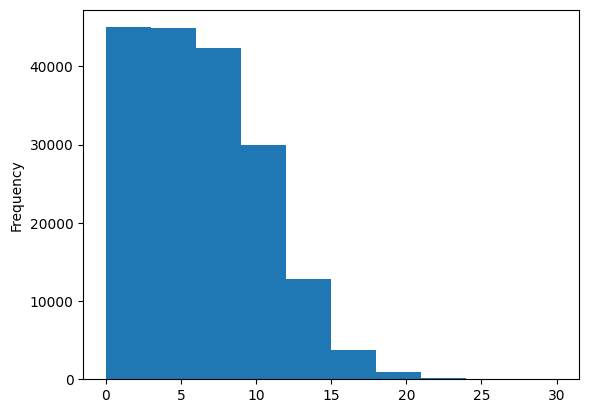

In [ ]:
# Check the distribution of "line_number" column
train_df.line_number.plot.hist()

In [ ]:
# Use Tensorflow to create one-hot-encoded tensors of our "line_number" column
train_line_numbers_one_hot =tf.one_hot(train_df["line_number"].to_numpy(),depth=15 )
val_line_numbers_one_hot=tf.one_hot(val_df["line_number"].to_numpy(),depth=15)
test_line_numbers_one_hot=tf.one_hot(test_df["line_number"].to_numpy(),depth=15)

In [ ]:
train_line_numbers_one_hot[:14],train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(14, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.

In [ ]:
# How many different numbers of line are there?
train_df["total_lines"].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

<Axes: ylabel='Frequency'>

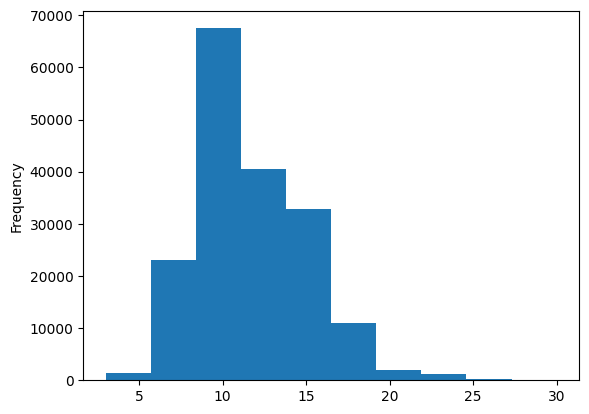

In [ ]:
# Check the distributions of total lines
train_df.total_lines.plot.hist()

In [ ]:
# Check the  coverage of a "total_lines" value of 20

np.percentile(train_df.total_lines,98)

20.0

In [ ]:
 # Use TensorFlow to create one-hot-encoded tensors of our "total_lines" features

 train_total_lines_one_hot=tf.one_hot(train_df["total_lines"].to_numpy(),depth=20)
 val_total_lines_one_hot=tf.one_hot(val_df["total_lines"].to_numpy(),depth=20)
 test_total_lines_one_hot=tf.one_hot(test_df["total_lines"].to_numpy(),depth=20)

 train_total_lines_one_hot.shape,train_total_lines_one_hot[:10]

(TensorShape([180040, 20]),
 <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0

# Building a tribrid embedding model

It's time to build the biggest model we've built yet.One which incorporates token embeddings,character embeddings and our newly crafted positional embeddings.

More specifically we're going to go through the following steps:

1. Create a token-level model(similar to `model_1`)
2. Create a character-level model (similar to `model_3` with a slight modification to reflect the paper)
3.Create a `"line_number"` model(takes in one-hot encoded `"line_number"` tensor and passes it through a non-linear layer)
4. Create a `"total_lines"` model(takes in one-hot-encoded`"total_lines` tensor and passes it through a non-linear layer)
5. Combine (using `layers.Concatenate`) the outputs of 1 and 2 into a token-character-hybrid embedding.

In [ ]:
train_total_lines_one_hot.shape

TensorShape([180040, 20])

In [ ]:
# 1. Token inputs
token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Char inputs
char_inputs = layers.Input(shape=(1,), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(32))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Line numbers inputs
line_number_inputs = layers.Input(shape=(15,), dtype=tf.int32, name="line_number_input")
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)

# 4. Total lines inputs
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.int32, name="total_lines_input")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_line_model = tf.keras.Model(inputs=total_lines_inputs,
                                  outputs=y)

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name="token_char_hybrid_embedding")([token_model.output,
                                                                              char_model.output])
z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embeddings with combined token and char embeddings into a tribrid embedding
z = layers.Concatenate(name="token_char_positional_embedding")([line_number_model.output,
                                                                total_line_model.output,
                                                                z])

# 7. Create output layer
output_layer = layers.Dense(5, activation="softmax", name="output_layer")(z)

# 8. Put together model
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_line_model.input,
                                 token_model.input,
                                 char_model.input],
                         outputs=output_layer,
                         name="model_5_tribrid_embedding_model"
                         )

_There's a lot going on here... let's visualize what's happening with a summary by plotting our model.

In [ ]:
# Get a summary of our token char and positonal embedding model
model_5.summary()

Model: "model_5_tribrid_embedding_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_inputs (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 token_inputs (InputLayer)   [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_inputs[0][0]']         
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978   

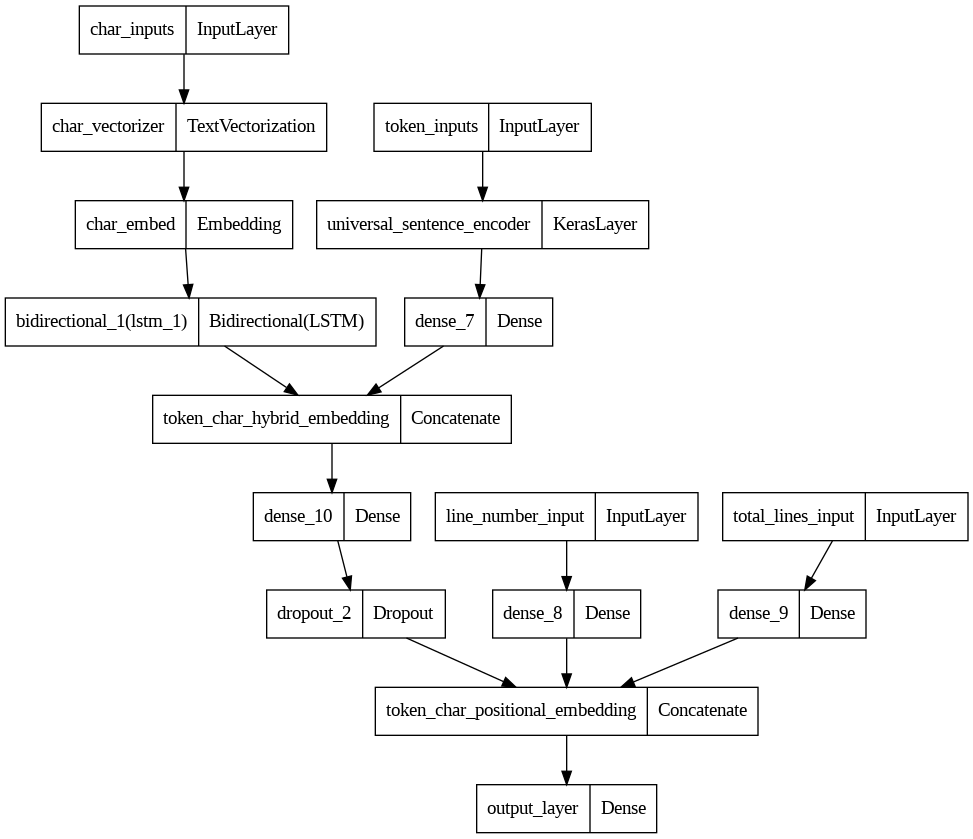

In [ ]:
# Plot the token, char ,positional embedding model
from tensorflow.keras.utils import plot_model
plot_model(model_5)

Visualizing the model makes it much easier to understand.

Essentially what we're doing is trying to encode as much information about our sequences as possible into various embeddings (the inputs to our model) so our model has the best chance to figure out what label belongs to a sequence (the outputs of our model).



# Now our model is constructed ,let's compile it.

This time we're going to introduce a new parameter to our loss function call `label smoothing`.Label smoothing helps to regularize our model(prevent  overfitting) by making sure it does'nt get too focused on applying one particular label to a sample.


For example ,instead of having an output prediction of :
`[0.0,0.0,1.0,0.0,0.0]` for a sample(the model is very confident the right label is index 2)



It's predictions will get smooothed to be something like:
`[0.01,0.01,0.096,0.01,0.01]` giving a small activation to each of the other labels, in turn hopefully improving generalization


In [ ]:
# Compile token,char,positional embedding model
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


In [ ]:
train_df["target"]

0           OBJECTIVE
1             METHODS
2             METHODS
3             METHODS
4             METHODS
             ...     
180035        RESULTS
180036        RESULTS
180037        RESULTS
180038    CONCLUSIONS
180039    CONCLUSIONS
Name: target, Length: 180040, dtype: object

# Create tribrid embedding datasets and fit tribird model

Model compiled!

Again,to keep our experiments swift, let's fit on 20,000 examples for 3 epochs.

This time our model requires four feature inputs:

1.Train line numbers one-hot tensor(`train_line_numbers_one_hot`)
2.Train total lines one-hot tensor(`train_total_lines_one_hot`)
3.Token-level sequences tensor(train_sentences)
4.Char-level sequences tensor(`train_chars`)

We can pass these as tuples to our `tf.data.Dataset.from_tensor_slices()` method to create appropriately shaped and batched `PrefetchedDataset's`.

In [ ]:
# Create training and validation datasets(all four kinds of inputs)


train_pos_char_token_data=tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                             train_total_lines_one_hot,
                                                             train_sentences,
                                                             train_chars)
                                                             )
train_pos_char_token_labels=tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_pos_char_token_dataset=tf.data.Dataset.zip((train_pos_char_token_data,train_pos_char_token_labels))
train_pos_char_token_dataset=train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Validation dataset

val_pos_char_token_data=tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                            val_total_lines_one_hot,
                                                            val_sentences,
                                                        val_chars))

val_pos_char_token_labels=tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_char_token_dataset=tf.data.Dataset.zip((val_pos_char_token_data,val_pos_char_token_labels))
val_pos_char_token_dataset=val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Check input shapes
train_pos_char_token_dataset,val_pos_char_token_dataset





(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [ ]:
# Fit the token, char and positional embedding model

history_model_5=model_5.fit(train_pos_char_token_dataset,
                            steps_per_epoch=int(0.1*len(train_pos_char_token_dataset)),
                            epochs=3,
                            validation_data=val_pos_char_token_dataset,
                            validation_steps=int(0.1*len(val_pos_char_token_dataset))
                            )

Epoch 1/3
562/562 [==============================] - 29s 42ms/step - loss: 1.0898 - accuracy: 0.7337 - val_loss: 0.9787 - val_accuracy: 0.8068
Epoch 2/3
562/562 [==============================] - 21s 37ms/step - loss: 0.9597 - accuracy: 0.8233 - val_loss: 0.9474 - val_accuracy: 0.8344
Epoch 3/3
562/562 [==============================] - 22s 39ms/step - loss: 0.9455 - accuracy: 0.8262 - val_loss: 0.9416 - val_accuracy: 0.8318


In [ ]:
32*562

17984

In [ ]:
# Make predictions with token-char-positonal hybrid model
model_5_pred_probs=model_5.predict(val_pos_char_token_dataset,verbose=1)
model_5_pred_probs

945/945 [==============================] - 21s 21ms/step


array([[0.4914923 , 0.10708818, 0.01287969, 0.36634097, 0.02219883],
       [0.5133565 , 0.09792395, 0.04952965, 0.32831708, 0.01087281],
       [0.26606858, 0.11550705, 0.12211087, 0.43173963, 0.06457385],
       ...,
       [0.05034725, 0.11089165, 0.06874935, 0.03501156, 0.73500013],
       [0.02997599, 0.24056709, 0.09166671, 0.02182682, 0.61596334],
       [0.1421841 , 0.73185945, 0.04009888, 0.03728659, 0.04857095]],
      dtype=float32)

In [ ]:
model_5_pred_probs.shape

(30212, 5)

In [ ]:
# Turn predictions probabilities into prediction classes

model_5_preds=tf.argmax(model_5_pred_probs,axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

# to know more about argmax [argmax_documentation](https://www.kdnuggets.com/2022/07/using-numpy-argmax.html)

In [ ]:
# Turn prediction probabilities into prediction classes
model_5_preds=tf.argmax(model_5_pred_probs,axis=1)

In [ ]:
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [ ]:
# Calculate results of token-char-positional hybrid model
model_5_results=calculate_results(y_true=val_labels_encoded,
                                  y_pred=model_5_preds)
model_5_results

{'accuracy': 83.30133721699987,
 'precision': 0.8317000396453296,
 'recall': 0.8330133721699987,
 'f1': 0.831783715935125}

# Compare model results

Far out , we've come a long way. From a baseline model to training a model containing three different kjnds of embeddings.

Now it's time to compare each model's performance against each other.

since all of our model results are in dictionaries.let's combine them into a pandas DataFrame to visualize them.

In [ ]:
# Combine model results into a DataFrame

all_model_results=pd.DataFrame({"baselline":baseline_results,
                                "custom_token_embed":model_1_results,
                                "pretrained_token_embed":model_2_results,
                                "custom_char_embed_conv1d":model_3_results,
                                "hybrid_char_token_embed":model_4_results,
                                "tribrid_pos_char_token_embed":model_5_results})
all_model_results=all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baselline,72.183238,0.718647,0.721832,0.698925
custom_token_embed,68.869985,0.679458,0.688700,0.659630
pretrained_token_embed,68.012710,0.681558,0.680127,0.671498
custom_char_embed_conv1d,69.184430,0.696328,0.691844,0.681616
hybrid_char_token_embed,74.294982,0.746465,0.742950,0.740263
tribrid_pos_char_token_embed,83.301337,0.831700,0.833013,0.831784


In [ ]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"]=all_model_results["accuracy"]/100

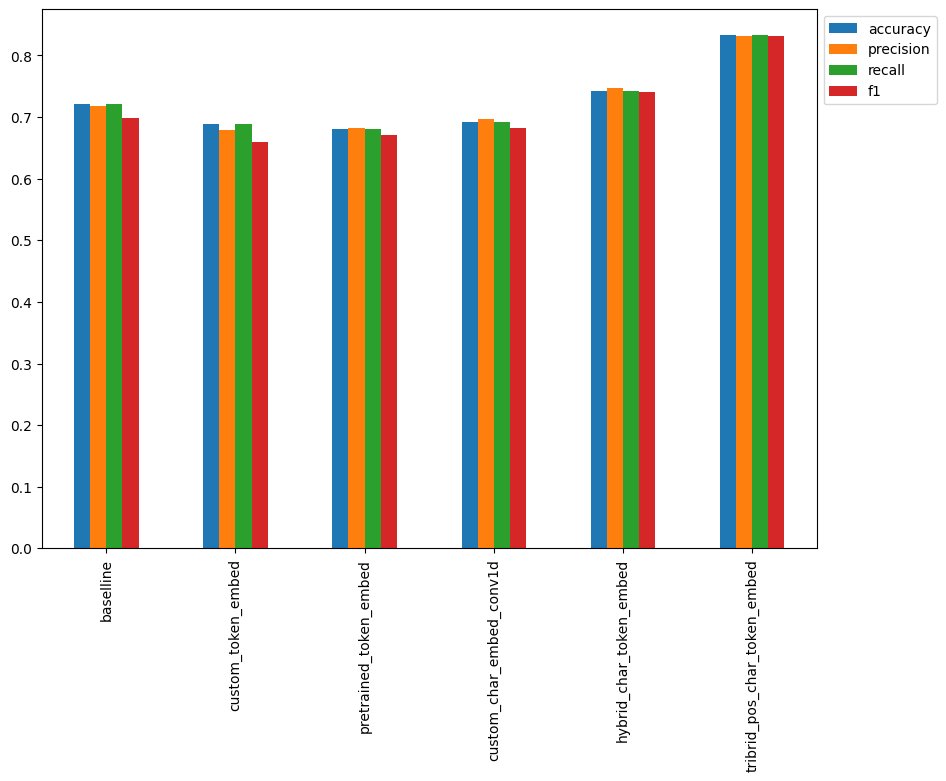

In [ ]:
# Plot and compare all of the model results

all_model_results.plot(kind="bar",figsize=(10,7)).legend(bbox_to_anchor=(1.0,1.0));

# Lets compare the F1-scores of our models on the test dataset

<Axes: >

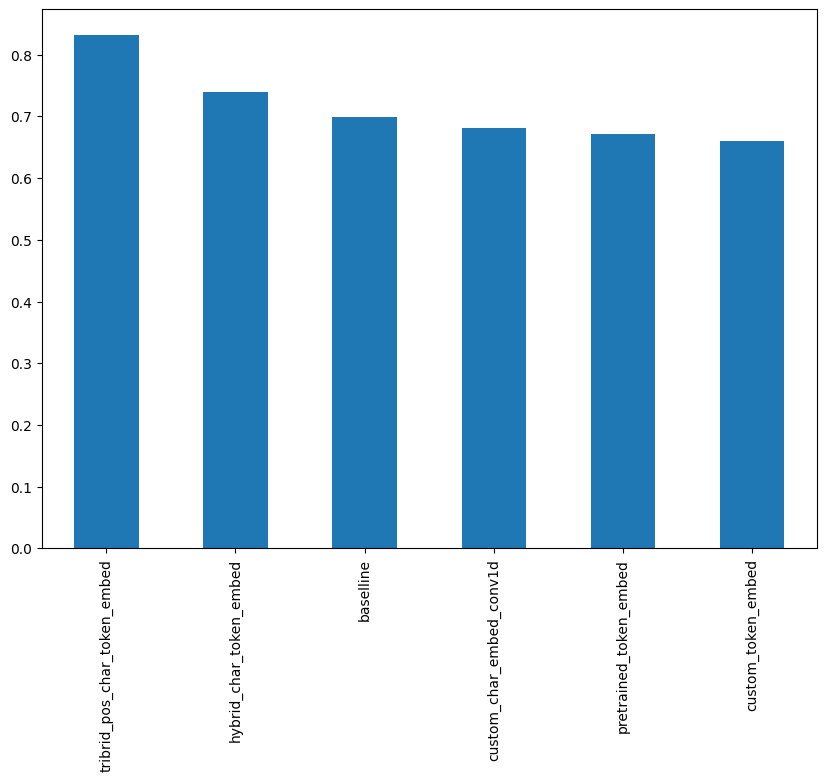

In [ ]:
# Sort model results by f1-score
all_model_results.sort_values("f1",ascending=False)["f1"].plot(kind="bar",figsize=(10,7))

# Nice! Based on F1-scores, it looks like our tribird embedding model performs the best by a fair margin.

There are some things to note about this difference:


*   Our models(with an exception for the baseline) we have on ~180,000(10% of batches) samples of sequences and labels rather than the full ~180,000 in the 20k RCT dataset.
*  This is often the case in machine learning experiments though,make sure training works on a smaller number of samples,then upscale when needed(an extension to this project will be training a model on the full dataset)


*  Our model's prediction performance levels have been evaluated on the validation dataset not the test dataset(we'll evaluate our best model on the test dataset shortly)






# Save and load best performing model

Since we've been through a fair few experiments,it's a good idea to save our best performing model so we can reuse it without having to retrain it.

 # We can save our best performing model to SaveModel format(Default)

In [ ]:
# Save best performing model to SavedModel format(default)
model_5.save("skimlit_tribrid_model") # model will be saved to path specified by string

In [ ]:


# Download pretrained model from Google Storage
!wget https://storage.googleapis.com/ztm_tf_course/skimlit/skimlit_tribrid_model.zip
!mkdir skimlit_gs_model
!unzip skimlit_tribrid_model.zip -d skimlit_gs_model

--2024-01-24 04:06:05--  https://storage.googleapis.com/ztm_tf_course/skimlit/skimlit_tribrid_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.207, 2607:f8b0:4023:c03::cf, 2607:f8b0:4023:c0d::cf
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 962182847 (918M) [application/zip]
Saving to: ‘skimlit_tribrid_model.zip’

skimlit_tribrid_mod 100%[===================>] 917.61M  91.2MB/s    in 13s     

2024-01-24 04:06:18 (73.4 MB/s) - ‘skimlit_tribrid_model.zip’ saved [962182847/962182847]

Archive:  skimlit_tribrid_model.zip
   creating: skimlit_gs_model/skimlit_tribrid_model/
  inflating: skimlit_gs_model/skimlit_tribrid_model/keras_metadata.pb  
   creating: skimlit_gs_model/skimlit_tribrid_model/assets/
 extracting: skimlit_gs_model/skimlit_tribrid_model/fingerprint.pb  
   creating: skimlit_gs_model/skimlit_tribrid_model/variables/
  inflating: skimlit_gs

In [ ]:

# Import TensorFlow model dependencies (if needed) - https://github.com/tensorflow/tensorflow/issues/38250
import tensorflow_hub as hub
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

model_path = "skimlit_gs_model/skimlit_tribrid_model/"

# Load downloaded model from Google Storage
loaded_model = tf.keras.models.load_model(model_path)#,

# Make predictions and evalaute them against the truth labels

To make sure our model saved and loaded correctly,let's make predicitons with it,evaluate them and then compare them to the prediction results we calculated earlier.

In [ ]:
# Make predictions with the loaded model on the validation set

loaded_pred_probs=loaded_model.predict(val_pos_char_token_dataset,verbose=1)
loaded_preds=tf.argmax(loaded_pred_probs,axis=1)
loaded_preds[:10]

945/945 [==============================] - 20s 20ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 3, 2, 2, 4, 4, 4, 4, 1])>

In [ ]:
# Evaluate loaded model's predictions
loaded_model_results=calculate_results(val_labels_encoded,
                                       loaded_preds)

loaded_model_results

{'accuracy': 83.03323182841254,
 'precision': 0.8290556618130785,
 'recall': 0.8303323182841255,
 'f1': 0.8294263092000485}

In [ ]:
# Compare loaded model results with original trained model results(should be quite close)

np.isclose(list(model_5_results.values()),list(loaded_model_results.values()),rtol=1e-02)

array([ True,  True,  True,  True])

# It's wroth nothing that loading in a
SavedModel unfreezes all layers(makes them all traiable).So if you want to freeze any layers,you'll have to set their trainable attribute to `False`.

In [ ]:
# Check loaded model summary(note the number of trainable parameters)
loaded_model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_inputs (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 token_inputs (InputLayer)   [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_inputs[0][0]']         
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978   ['token_inputs[0][0]']  

# Evaluate model on test dataset

In [ ]:
# Create test dataset batch and prefetched
test_pos_char_token_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,
                                                               test_total_lines_one_hot,
                                                               test_sentences,
                                                               test_chars))
test_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_pos_char_token_dataset = tf.data.Dataset.zip((test_pos_char_token_data, test_pos_char_token_labels))
test_pos_char_token_dataset = test_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Check shapes
test_pos_char_token_dataset



<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
# Make predictions on the test dataset

test_pred_probs=loaded_model.predict(test_pos_char_token_dataset,
                                     verbose=1)
test_preds=tf.argmax(test_pred_probs,axis=1)
test_preds[:10]

942/942 [==============================] - 18s 20ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([3, 3, 2, 2, 4, 4, 4, 1, 1, 0])>

In [ ]:
# Evaluate loaded model test predictions

loaded_model_test_results=calculate_results(y_true=test_labels_encoded,
                                       y_pred=test_preds)
loaded_model_test_results

{'accuracy': 82.57176041148166,
 'precision': 0.8242659626849546,
 'recall': 0.8257176041148167,
 'f1': 0.8247141207593822}

It seems our best model (so far) still has some ways to go to match the performance of the results in the paper (their model gets 90.0 F1-score on the test dataset, where as ours gets ~82.1 F1-score).

However, as we discussed before our model has only been trained on 20,000 out of the total ~180,000 sequences in the RCT 20k dataset. We also haven't fine-tuned our pretrained embeddings (the paper fine-tunes GloVe embeddings). So there's a couple of extensions we could try to improve our results.

# Find most wrong

One of the best ways to investigate wheere your model is going wrong(or potentially wehre your data is wrong) is to visulaize the "most wrong" predictions
The most wrong predictions are samples where the model has made a prediction with a high probability but has gotten it wrong (the model's prediction disagreess with the ground truth label).

Looking at the most wrong predictions can give us valuable information on how to improve further models or fix the labels in our data.

Let's write some code to help us visualize the most wrong predictions from the test dataset.

First we'll convert all of our integer-based test predictions into their string-based class names.



In [ ]:
%%time
# Get list of class names of test predictions
test_pred_classes = [Label_encoder.classes_[pred] for pred in test_preds]
test_pred_classes

CPU times: user 14.2 s, sys: 824 ms, total: 15 s
Wall time: 14.2 s


['OBJECTIVE',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'BACKGROUND',
 'BACKGROUND',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'OBJECTIVE',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'BACKGROUND',
 'METHODS',
 'BACKGROUND',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'BACKGROUND',
 'BACKGROUND',
 'BACKGROUND',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'METHODS',
 'CONCLUSIONS',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'METHODS',
 'RESULTS',
 'RESULTS

# Now we'll enrich our test DataFame with a few values:

1.A "prediction" (string) column containing our model's prediction for a given sample.

2.A "pred_prob" (float) column containing the model's maximum prediction probabiliy for a given sample.

3.A "correct" (bool) column to indicate whether or not the model's prediction matches the sample's target label.

In [ ]:
# Create prediction enriched test dataframe
test_df["prediction"]=test_pred_classes # create column with test prediction class names
test_df["pred_prob"]=tf.reduce_max(test_pred_probs,axis=1)# get the maximum prediction probaility
test_df["correct"]=test_df["prediction"]==test_df["target"] # crearte binary column for whether the prediction is correct or not
test_df.head(20)

,target,text,line_number,total_lines,prediction,pred_prob,correct
0,BACKGROUND,this study analyzed liver function abnormaliti...,0,8,OBJECTIVE,0.523885,False
1,RESULTS,a post hoc analysis was conducted with the use...,1,8,OBJECTIVE,0.351917,False
2,RESULTS,liver function tests ( lfts ) were measured at...,2,8,METHODS,0.802459,False
3,RESULTS,survival analyses were used to assess the asso...,3,8,METHODS,0.652782,False
4,RESULTS,the percentage of patients with abnormal lfts ...,4,8,RESULTS,0.665070,True
5,RESULTS,when mean hemodynamic profiles were compared i...,5,8,RESULTS,0.881815,True
6,RESULTS,multivariable analyses revealed that patients ...,6,8,RESULTS,0.529839,True
7,CONCLUSIONS,abnormal lfts are common in the adhf populatio...,7,8,CONCLUSIONS,0.568003,True
8,CONCLUSIONS,elevated meld-xi scores are associated with po...,8,8,CONCLUSIONS,0.461431,True
9,BACKGROUND,minimally invasive endovascular aneurysm repai...,0,12,BACKGROUND,0.537819,True


test_df[:10]

Looking good! Having our data like this, makes it very easy to manipulate and view in different ways.

How about we sort our DataFrame to find the samples with the highest `"pred_prob"` and where the prediction was wrong `("correct" == False)`?

In [ ]:
# Find top 100 most wrong samples(note:100 is an arbitary number,you could go through all of them if you wanted)
top_100_wrong=test_df[test_df["correct"]==False].sort_values("pred_prob",ascending=False)[:100]

In [ ]:
top_100_wrong

,target,text,line_number,total_lines,prediction,pred_prob,correct
13874,CONCLUSIONS,symptom outcomes will be assessed and estimate...,4,6,METHODS,0.946719,False
8545,METHODS,pretest-posttest .,1,11,BACKGROUND,0.934974,False
16347,BACKGROUND,to evaluate the effects of the lactic acid bac...,0,12,OBJECTIVE,0.930986,False
2388,RESULTS,the primary endpoint is the cumulative three-y...,4,13,METHODS,0.928262,False
10452,BACKGROUND,to validate the association between accommodat...,0,10,OBJECTIVE,0.918880,False
...,...,...,...,...,...,...,...
12134,RESULTS,we conducted a population-based case-control s...,2,16,METHODS,0.840899,False
2605,RESULTS,"circulating epc ( cells positive for cd@ , cd@...",4,10,METHODS,0.840442,False
19223,METHODS,"of the @ dogs receiving placebo , @ ( @ % ) vo...",7,10,RESULTS,0.840310,False
20003,CONCLUSIONS,most subjects with bronchospasm responded to r...,9,11,RESULTS,0.839986,False


Great (or not so great)! Now we've got a subset of our model's most wrong predictions, let's write some code to visualize them.

In [ ]:
# Investigate top wrong preds
for row in top_100_wrong[0:10].itertuples(): # adjust indexes to view different samples
  _, target, text, line_number, total_lines, prediction, pred_prob, _ = row
  print(f"Target: {target}, Pred: {prediction}, Prob: {pred_prob}, Line number: {line_number}, Total lines: {total_lines}\n")
  print(f"Text:\n{text}\n")
  print("-----\n")

Target: CONCLUSIONS, Pred: METHODS, Prob: 0.9467191696166992, Line number: 4, Total lines: 6

Text:
symptom outcomes will be assessed and estimates of cost-effectiveness made .

-----

Target: METHODS, Pred: BACKGROUND, Prob: 0.9349740743637085, Line number: 1, Total lines: 11

Text:
pretest-posttest .

-----

Target: BACKGROUND, Pred: OBJECTIVE, Prob: 0.9309859275817871, Line number: 0, Total lines: 12

Text:
to evaluate the effects of the lactic acid bacterium lactobacillus salivarius on caries risk factors .

-----

Target: RESULTS, Pred: METHODS, Prob: 0.9282616972923279, Line number: 4, Total lines: 13

Text:
the primary endpoint is the cumulative three-year hiv incidence .

-----

Target: BACKGROUND, Pred: OBJECTIVE, Prob: 0.918879508972168, Line number: 0, Total lines: 10

Text:
to validate the association between accommodation and visual asthenopia by measuring objective accommodative amplitude with the optical quality analysis system ( oqas , visiometrics , terrassa , spain ) 

# Make example predictions

okay, we've made some predictions on the test dataset, now's time to really test our model out.

To do so, we're going to get some data from the wild and see how our model performs.


In other words,were going to find an RCT abstract from PubMed , preprocess the text so it works our model, then pass each sequence in the wild abstract through our model to see what label it predicts.


As you might've guessed the above abstract hasn't been formatted in the same as the data our model has been trained on . Therefore, before we can make a prediction on it we need to preprocess it just as we have our other sequences.

More specifically , for each abstract, we'll need to:

1.Split it into sentences(line).

2.Split it into characters.

3.Find the number of each line.

4.Find the total number of lines.



Starting with number 1, there are a couple of ways to split our abstracts into actual sentences. A simple one would be to use Python's in-built `split()` string method, splitting the abstract wherever a fullstop appears. However, can you imagine where this might go wrong?

Another more advanced option would be to leverage `spaCy's` (a very powerful NLP library) sentencizer class. Which is an easy to use sentence splitter based on spaCy's English language model.

In [ ]:
import json
# Download and open example abstracts (copy and pasted from PubMed)
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json

with open("skimlit_example_abstracts.json", "r") as f:
  example_abstracts = json.load(f)

example_abstracts


--2024-01-24 04:37:18--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6737 (6.6K) [text/plain]
Saving to: ‘skimlit_example_abstracts.json’

skimlit_example_abs 100%[===================>]   6.58K  --.-KB/s    in 0s      

2024-01-24 04:37:18 (64.7 MB/s) - ‘skimlit_example_abstracts.json’ saved [6737/6737]



[{'abstract': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs. Participants were randomly assigned to treatment or wait-list conditions. Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language. A response-cost program was applied to reduce problem behaviors and foster skills acquisition. Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures). Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents. High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity. Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.',
  'source': 'https://pubmed.ncbi.nlm.nih.gov/20232240/',
  'details': 'RCT of a manualiz

In [ ]:
# See what our example abstracts look like
abstracts=pd.DataFrame(example_abstracts)
abstracts

,abstract,source,details
0,This RCT examined the efficacy of a manualized...,https://pubmed.ncbi.nlm.nih.gov/20232240/,RCT of a manualized social treatment for high-...
1,Postpartum depression (PPD) is the most preval...,https://pubmed.ncbi.nlm.nih.gov/28012571/,Formatting removed (can be used to compare mod...
2,"Mental illness, including depression, anxiety ...",https://pubmed.ncbi.nlm.nih.gov/28942748/,Effect of nutrition on mental health
3,Hepatitis C virus (HCV) and alcoholic liver di...,https://pubmed.ncbi.nlm.nih.gov/22244707/,Baclofen promotes alcohol abstinence in alcoho...


In [ ]:
type(abstracts)

pandas.core.frame.DataFrame

Now we've downloaded some example abstracts,let'see how one of them goes with our trained model.

First,we'll need to parse it using spaCy to turn it from a big chunk of text inot sentences



In [ ]:
# Create sentencizer - Source: https://spacy.io/usage/linguistic-features#sbd

from spacy.lang.en import English

nlp=English() # setuo English sentence parser

# New version of SpaCy

sentencizer=nlp.add_pipe("sentencizer") # create sentence splitting pipeline objects

# Create "doc" of parsed sequences ,change index for a different abstract
doc=nlp(example_abstracts[0]["abstract"])
abstract_lines=[str(sent) for sent in list(doc.sents)] # return detected sentences from doc in string type
abstract_lines

['This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
 'Participants were randomly assigned to treatment or wait-list conditions.',
 'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
 'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
 'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
 'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
 'High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.',
 'Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.']

In [ ]:
type(doc)

spacy.tokens.doc.Doc

`Parse a string`

Create a function that takes a string as input and returns a list of all words in the >string. It should remove all punctuation, replacing dashes with spaces.

# Doc
A Doc is a sequence of Token objects. Access sentences and named entities, export annotations to numpy arrays, losslessly serialize to compressed binary strings. The Doc object holds an array of TokenC structs. The Python-level Token and Span objects are views of this array, i.e. they don’t own the data themselves.

[documentation](https://spacy.io/api/doc)




`Enumerate`: The enumerate function is a built-in function that allows you to iterate through a sequence and keep track of the index of each element.

In [ ]:
# Get total number of lines

total_lines_in_sample=len(abstract_lines)

# Go through each line in abstract and create a list of dictionaries containing features for each line.
sample_lines=[]
for i,line in enumerate(abstract_lines):
  sample_dict={}
  sample_dict["text"]=str(line)
  sample_dict["line_number"]=i
  sample_dict["total_lines"]=total_lines_in_sample-1
  sample_lines.append(sample_dict)
sample_lines

[{'text': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
  'line_number': 0,
  'total_lines': 7},
 {'text': 'Participants were randomly assigned to treatment or wait-list conditions.',
  'line_number': 1,
  'total_lines': 7},
 {'text': 'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
  'line_number': 2,
  'total_lines': 7},
 {'text': 'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
  'line_number': 3,
  'total_lines': 7},
 {'text': 'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
  'line_number': 4,
  'total_lines': 7},
 {'text': 'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
  'line_number': 5,
  'total_lines': 7},
 {'text'

In [ ]:
# Get all line_number values form sample abstract
test_abstract_line_numbers=[line["line_number"] for line in  sample_lines]
# one-hot encode to same depth as training data,so model accepts right input shape
test_abstract_line_numbers_one_hot=tf.one_hot(test_abstract_line_numbers,depth=15)
test_abstract_line_numbers_one_hot

<tf.Tensor: shape=(8, 15), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],
      dtype=float32)>

We can also use our `split_chars()` function to split our abstract lines into characters

In [ ]:

# Split abstract lines into characters
abstract_chars = [split_chars(sentence) for sentence in abstract_lines]
abstract_chars

['T h i s   R C T   e x a m i n e d   t h e   e f f i c a c y   o f   a   m a n u a l i z e d   s o c i a l   i n t e r v e n t i o n   f o r   c h i l d r e n   w i t h   H F A S D s .',
 'P a r t i c i p a n t s   w e r e   r a n d o m l y   a s s i g n e d   t o   t r e a t m e n t   o r   w a i t - l i s t   c o n d i t i o n s .',
 'T r e a t m e n t   i n c l u d e d   i n s t r u c t i o n   a n d   t h e r a p e u t i c   a c t i v i t i e s   t a r g e t i n g   s o c i a l   s k i l l s ,   f a c e - e m o t i o n   r e c o g n i t i o n ,   i n t e r e s t   e x p a n s i o n ,   a n d   i n t e r p r e t a t i o n   o f   n o n - l i t e r a l   l a n g u a g e .',
 'A   r e s p o n s e - c o s t   p r o g r a m   w a s   a p p l i e d   t o   r e d u c e   p r o b l e m   b e h a v i o r s   a n d   f o s t e r   s k i l l s   a c q u i s i t i o n .',
 'S i g n i f i c a n t   t r e a t m e n t   e f f e c t s   w e r e   f o u n d   f o r   f i v e   o f   s e v e n   p 

Alright, now we've preprocessed our wild RCT abstract into all of the same features our model was trained on, we can pas these features to our model and make sequence label predictions!



In [ ]:

# Get all total_lines values from sample abstract
test_abstract_total_lines = [line["total_lines"] for line in sample_lines]
# One-hot encode to same depth as training data, so model accepts right input shape
test_abstract_total_lines_one_hot = tf.one_hot(test_abstract_total_lines, depth=20)
test_abstract_total_lines_one_hot

<tf.Tensor: shape=(8, 20), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]], dtype=float32)>

In [ ]:
# Make predictions on sample abstract features
%%time
test_abstract_pred_probs = loaded_model.predict(x=(test_abstract_line_numbers_one_hot,
                                                   test_abstract_total_lines_one_hot,
                                                   tf.constant(abstract_lines),
                                                   tf.constant(abstract_chars)))
test_abstract_pred_probs

1/1 [==============================] - 1s 1s/step
CPU times: user 1.26 s, sys: 12.8 ms, total: 1.28 s
Wall time: 1.24 s


array([[0.26448247, 0.11054242, 0.01762423, 0.5750656 , 0.03228523],
       [0.06927066, 0.03808297, 0.7078093 , 0.09543166, 0.08940544],
       [0.13772687, 0.04937517, 0.5467969 , 0.1634129 , 0.10268808],
       [0.09659057, 0.17111638, 0.5257439 , 0.07601643, 0.13053273],
       [0.04459697, 0.08888113, 0.45675445, 0.04623033, 0.36353713],
       [0.03265215, 0.14626428, 0.517485  , 0.04088319, 0.2627154 ],
       [0.03290154, 0.17796218, 0.07166825, 0.02870874, 0.6887593 ],
       [0.0184372 , 0.1349517 , 0.3208419 , 0.03389723, 0.49187198]],
      dtype=float32)

In [ ]:
# Turn prediction probailites into prediction classes
test_abstract_preds=tf.argmax(test_abstract_pred_probs,axis=1)
test_abstract_preds

<tf.Tensor: shape=(8,), dtype=int64, numpy=array([3, 2, 2, 2, 2, 2, 4, 4])>

Now we've got the predicted sequence label for each line in our sample abstract,let's write some code to visualize each sentence with its predicted label.

In [ ]:
# Turn prediction class integers into string class names
test_abstract_pred_classes=[Label_encoder.classes_[i] for i in test_abstract_preds]
test_abstract_pred_classes

['OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS']

In [ ]:
# Visualize abstract lines and predicted sequence labels
for i ,line in enumerate(abstract_lines):
  print(f"{test_abstract_pred_classes[i]}:{line}")

OBJECTIVE:This RCT examined the efficacy of a manualized social intervention for children with HFASDs.
METHODS:Participants were randomly assigned to treatment or wait-list conditions.
METHODS:Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.
METHODS:A response-cost program was applied to reduce problem behaviors and foster skills acquisition.
METHODS:Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).
METHODS:Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.
RESULTS:High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.
RESULTS:Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.
